# GTD2 notebook

## 1. Adat és módszer

**Feladatunk a terrorizmus tulajdonságainak kontintens- és országfüggőségének vizualizálása, valamint a terrorcselekmények klasszifikációja az áldozatok száma alapján.**

GTD2 adatkészlet esetén terrorizmus az a cselekmény, melyre az alábbi pontok közül legalább kettő teljesül:
1. Az erőszakos cselekedet célja egy politikai, gazdasági, vallási vagy társadalmi cél elérése volt.
2. Az erőszakos cselekedet során egyértelmű volt a szándékos kényszerítés, megfélemlítés, vagy valamely más üzenet közvetítése egy nagyobb közönségnek, nem csak az áldozatoknak.
3. Az erőszakos cselekedet során sérültek a nemzetközileg elismert emberi jogok.

Az adatok 1970 és 2016 között történt terrorcselekményeket tartalmazzák. 1970-től 1997-ig rendszeresen frissítették, utána 2007-ig viszont visszamenőleg vitték fel az ismert támadásokat. Ezáltal valószínűleg ez az időszak nem adja vissza a teljes képet. 2007 után újra bekerültek az aktuális történések.

A forrás részletes információkat tartalmaz az
* esemény idejéről, hosszáról
* incidensről (definíció szerinti értelmezése alapján)
* incidens helyéről
* támadásról (típusa, sikeressége)
* fegyverről (típusa, altípusa)
* célpontról/áldozatról (típusa, specifikussága, nemzeti jellege)
* elkövetőről (csoport, létszám, bizonyosság) 
* veszteségekről és következményekről (halálos áldozatok száma, sérültek száma, anyagi kár, túszok)
* egyéb információkról és forrásokról

---

## 2. EDA

### 2.1 Adatok beolvasása

Spark python könyvtár importálása, majd a spark környezet `sc` létrehozása lokál módban.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext('local', 'gtd2')
sqlc = SQLContext(sc)

Az adatokat `gtd.txt` tabulátorral elválasztott szöveges fájlból olvassuk ki. Majd egy `map` segítségével tagoljuk a tabulátor alapján az oszlopokat.

In [2]:
raw = sc.textFile("gtd.txt")
data = raw.map(lambda x: x.split('\t'))

# Segéd függvény, amely az adatnak az oszlop indexét adja vissza az oszlopnév alapján
def getIndexByKey(key):
    return data.take(1)[0].index(key)

### 2.2 Terrorcselekmények számának év szerinti összesítése

In [3]:
import pandas as pd

iyear = getIndexByKey('iyear')
rdd_years = data.map(lambda x: (x[iyear], 1))\
                .reduceByKey(lambda a, b: a+b)\
                .filter(lambda x: x[0]!='iyear')\
                .sortByKey(1)

years = rdd_years.collect()
df_years = pd.DataFrame.from_records(years, columns = ('year', 'count')).apply(pd.to_numeric)

A `df_years` tartalmazza az egyes években összesített terrorcselekmények számát. A `df_years_kill` változóban pedig az összes haláleset található évekre lebontva.

In [4]:
nkill = getIndexByKey('nkill')
rdd_years_kills = data.map(lambda x: (x[iyear], x[nkill]))\
                      .filter(lambda x: x[0]!='iyear')\
                      .sortByKey(1)
        
df_years_kill = pd.DataFrame.from_records(rdd_years_kills.collect(), columns = ('year', 'killed')).apply(pd.to_numeric)
df_years_kill = df_years_kill.groupby('year')\
                             .sum()\
                             .reset_index()

Statisztikai adatok számításához lesz rá szükség. TODO

In [5]:
from pyspark.mllib.stat import Statistics
import numpy as np
summary_year = Statistics.colStats(rdd_years)

In [6]:
print('46 év alatt átlagosan ennyi haláleset történt: ', df_years_kill['killed'].mean())
print(int(df_years_kill.max()['year']),'-ban/-ben történt a legtöbb (',int(df_years_kill.max()['killed']),') haláleset')

46 év alatt átlagosan ennyi haláleset történt:  8338.130434782608
2016 -ban/-ben történt a legtöbb ( 43566 ) haláleset


### 2.3 Terrorcselekmények az országokban
#### 2.3.1 Incidensek száma az országokban
Az `incidents_in_countries`-ban találhatóak az összes terrorcselekmény száma országokra bontva. Az első öt legtöbb terrorcselekményt tartalmazó ország megjelenítése.

In [7]:
country_txt = getIndexByKey('country_txt')
incidents_in_countries = data.map(lambda x: (x[country_txt], 1)).reduceByKey(lambda a,b: a+b)
incidents_in_countries = incidents_in_countries.map(lambda x: (x[1], x[0])).sortByKey(0)
incidents_in_countries.take(5)

[(22130, 'Iraq'),
 (13634, 'Pakistan'),
 (11306, 'Afghanistan'),
 (10978, 'India'),
 (8163, 'Colombia')]

#### 2.3.2 Halálesetek száma az egyes országokban

In [8]:
import pandas as pd

country = getIndexByKey('country_txt')
nkill = getIndexByKey('nkill')

rdd_country_kill = data.map(lambda x: (x[country], x[nkill]))\
                       .filter(lambda x: x[0]!='country_txt')\
                       .sortByKey(1)

country_kill = rdd_country_kill.collect()
df_country_kill = pd.DataFrame.from_records(country_kill, columns = ('country', 'killed'))
df_country_kill['killed'] = df_country_kill['killed'].apply(pd.to_numeric)
df_country_kill = df_country_kill.groupby('country').sum().reset_index()
df_country_kill

,country,killed
0,Afghanistan,33146.0
1,Albania,42.0
2,Algeria,11091.0
3,Andorra,NaN
4,Angola,3036.0
5,Antigua and Barbuda,NaN
6,Argentina,489.0
7,Armenia,37.0
8,Australia,19.0
9,Austria,28.0


### 2.4 Halálesetek száma régiókra vetítve

In [9]:
import pandas as pd

region = getIndexByKey('region')
nkill = getIndexByKey('nkill')
rdd_region_kill = data.map(lambda x: (x[region], x[nkill]))\
                      .filter(lambda x: x[0]!='region')\
                      .sortByKey(1)

region_kill = rdd_region_kill.collect()
df_region_kill = pd.DataFrame.from_records(region_kill, columns = ('region', 'killed')).apply(pd.to_numeric)
#df_region_kill['killed'] = df_region_kill['killed'].apply(pd.to_numeric)
df_region_kill = df_region_kill.groupby('region').sum().reset_index()
df_region_kill

,region,killed
0,1,4764.0
1,2,28704.0
2,3,28730.0
3,4,1138.0
4,5,14819.0
5,6,93434.0
6,7,993.0
7,8,6595.0
8,9,7311.0
9,10,125676.0


---

## 3. Vizualizációk 
### 3.1 Terrortámadások denzitása

Az alábbi vizualizációs blokk az összes terrorcselekményt ábrázolja a hosszúsági és szélességi adatok alapján.
A vizualizációhoz elsősorban a *datashader* könyvtárat használjuk. A codebook alapján, a hosszúsági és szélességi adatok WGS84-es formátumba vannak tárolva, viszont ahhoz, hogy megfelelően tudjuk ábrázolni a pontokat, WebMercator formátumba kell  projektálni a meglévő hosszúsági és szélességi adatokat. Ehhez a *pyproj* nevű könyvtárat használjuk. Ehhez egy-egy  függvényt (*toWebMLon* és *toWebMLat*) definiáltunk, ami megvalósítja a megfelelő projekciókat. A pozíciókat a *pandas* könyvtár segítségével egy dataframe-be tároljuk, amit feltudunk használni a vizualizációhoz. Az ábrán fekete alapra egy 
"hőtérkép"-hez hasonló eredményt várunk, vagyis adott térségben lévő színfoltok fogják jellemezni a terror cselekmények helybeli sűrűségét.

Később a *datashader* könyvtárat arra fogjuk használni, hogy kontinensekre, ill. országokra vetítve ábrázoljuk a terrorcselekmények számát. Minél több terrortámadás történt egy kontinensen vagy egy országban, az annál világosabb színt kap.

In [10]:
from pyproj import Proj, transform
import pandas as pd

# long/lat. adatok Web mercator formátumba konvertálásához
def toWebMLon(lon):
    loc = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, 0)
    return loc[0]

def toWebMLat(lat):
    loc = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 0, lat)
    return loc[1]

# indexek
longitude = getIndexByKey('longitude')
latitude = getIndexByKey('latitude')

points = data.map(lambda x: (x[longitude], x[latitude])).collect()

locations = pd.DataFrame.from_records(points[1:], columns = points[0]).replace({',': '.'}, regex=True)
locations = locations.apply(pd.to_numeric, errors='coerce').dropna()

locations['longitude'] = locations['longitude'].apply(toWebMLon)
locations['latitude'] = locations['latitude'].apply(toWebMLat)

In [11]:
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf

x_range = (locations['longitude'].min(), locations['longitude'].max())
y_range = (locations['latitude'].min(), locations['latitude'].max())

plot_width  = int(1000) # Minél nagyobb, annál jobb a felbontás, akár országon belüli eloszlás vizsgálatához
plot_height = int(plot_width*7.0/12)

cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)

agg = cvs.points(locations, 'longitude', 'latitude') 

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


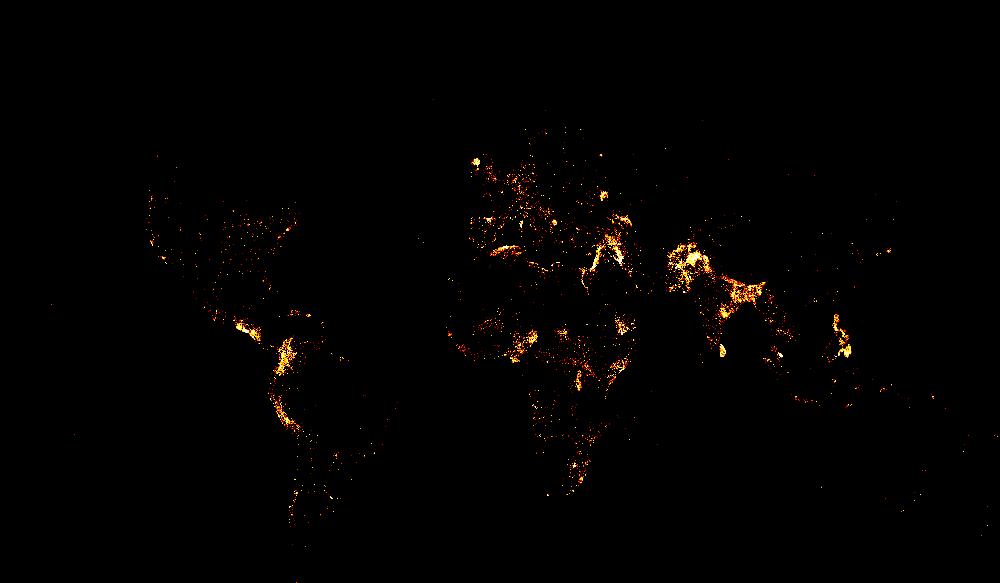

In [12]:
from functools import partial
from datashader.utils import export_image
from matplotlib.cm import hot

background = "black"
export = partial(export_image, background = background, export_path="export")

export(tf.shade(agg, cmap = hot, how='eq_hist'), "gtd_on_map")

### 3.2 Terrorcselekmények időbeli trendje
Az alábbi vizualizációs blokk egy egyszerű idősor diagram, amely ábrázolja, hogy egy évben mennyi terrorcselekmény történt, és az évek során hány halálos áldozat volt.

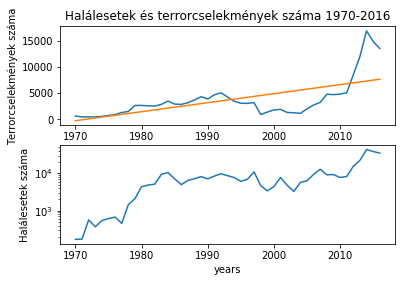

In [13]:
from math import log10
from matplotlib import pyplot as plt
import numpy as np

lg_counts = df_years['count'].apply(log10)
m, b = np.polyfit(df_years['year'], df_years['count'], 1)

fig = plt.figure()

pl1 = fig.add_subplot(211)
pl1.set_ylabel('Terrorcselekmények száma')
pl1.set_title('Halálesetek és terrorcselekmények száma 1970-2016')
plt.yscale('linear')
pl1.plot(df_years['year'], df_years['count'])
pl1.plot(df_years['year'], m*df_years['year']+b, '-')

pl2= fig.add_subplot(212)
pl2.set_ylabel('Halálesetek száma')
pl2.set_xlabel('years')
plt.yscale('log')
pl2.plot(df_years_kill['year'], df_years_kill['killed'])

plt.show()

### 3.3 Terrorcselekmények kontines és országfüggősége

A terrorcselekmények számát régiókra összesítettük a `df_region_kill` dataframe-ben.

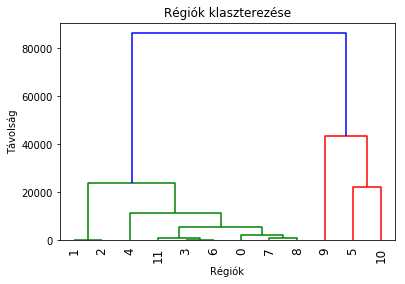

Cophenetic korráliciós együttható 0.914332921888


In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from matplotlib import pyplot as plt

Z = linkage(df_region_kill, 'average')

plt.title('Régiók klaszterezése')
plt.xlabel('Régiók')
plt.ylabel('Távolság')
dendrogram(Z, leaf_rotation=90)
plt.show()

c, coph_dists = cophenet(Z, pdist(df_region_kill))
print("Cophenetic korráliciós együttható", c)

---

## 4. Klasszifikáció  

Klasszifikálnunk kell az incidenseket az áldozatok száma alapján. Alkothatnánk például 4 osztályt a percentilisek alapján. Ne nekünk kelljen megmondani, hogy 10 alatt kevésnek számít, 100 felett meg soknak. Beszéljenek a számok! Ha pl az adatkészlet alapján az esetek 25%-ában kevesebben haltak meg 20-nál, 20 legyen a legkevesebb áldozatot jelölő osztály.

In [15]:
nkill_column = data.map(lambda x: [x[nkill]]).filter(lambda x: x[0]!='nkill' and x[0]!='')
df = pd.DataFrame(nkill_column.collect(),columns=['nkill']).apply(pd.to_numeric)
df.quantile([0.25,0.5,0.75,1])

,nkill
0.25,0.0
0.50,0.0
0.75,2.0
1.00,1500.0


Hmm, ez fura. Vajon hogyan alakul az áldozatok száma az összes incidens esetén?

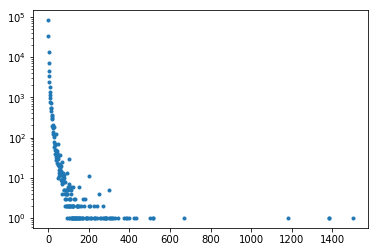

In [16]:
nkill_sum = data.map(lambda x: (x[nkill], 1)).filter(lambda x: x[0]!='nkill' and x[0]!='').reduceByKey(lambda a,b: a+b).sortByKey(1)
df2 = pd.DataFrame(nkill_sum.collect(), columns=['nkills','sum']).apply(pd.to_numeric)
plt.plot(df2['nkills'],df2['sum'], '.')
plt.yscale('log')
plt.show()

ÁHÁ! Így már jobban tudunk gondolkodni, hogyan osszuk be az osztályainkat sávokra. A percentilis ötlete nem jött be. :D

In [17]:
def getClassLabel(number):
    borders = (1,5,10,100) # i. oszályba tartozik egy incidens, ha a tömb i. indexű eleménél kevesebb áldozata volt
    for i in range(len(borders)):
        if int(number)<borders[i]:
            return i
    return len(borders)

nkill_classes = data.map(lambda x: x[nkill]).filter(lambda x: x!='nkill' and x!='').map(lambda x: (getClassLabel(x), 1)).reduceByKey(lambda a,b: a+b).sortByKey(1)
nkill_classes.collect()

[(0, 82925), (1, 59253), (2, 9892), (3, 8391), (4, 207)]

Alább egy demó látható a döntési fás tanításból.

In [18]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint

iyear = getIndexByKey('iyear')
imonth = getIndexByKey('imonth')
iday = getIndexByKey('iday')
extended = getIndexByKey('extended')
country = getIndexByKey('country')
region = getIndexByKey('region')
latitude = getIndexByKey('latitude')
longitude = getIndexByKey('longitude')
specificity = getIndexByKey('specificity')
vicinity = getIndexByKey('vicinity')
attacktype1 = getIndexByKey('attacktype1')
multiple = getIndexByKey('multiple')
success = getIndexByKey('success')
suicide = getIndexByKey('suicide')
targtype1 = getIndexByKey('targtype1')
targsubtype1 = getIndexByKey('targsubtype1')
natlty1 = getIndexByKey('natlty1')
guncertain1 = getIndexByKey('guncertain1')
individual = getIndexByKey('individual')
weaptype1 = getIndexByKey('weaptype1')
weapsubtype1 = getIndexByKey('weapsubtype1')
nwound = getIndexByKey('nwound')
proper = getIndexByKey('property')
propvalue = getIndexByKey('propvalue')
ishostkid = getIndexByKey('ishostkid')
ransom = getIndexByKey('ransom')

# az új adathalmazunk, címkékkel együtt
data_rdd_of_labeledpoints = data.map(lambda x: np.array(x))\
                                .filter(lambda x: x[nkill]!='nkill' and x[nkill]!='' and x[iyear]!='' and x[imonth]!=''
                                       and x[iday]!='' and x[extended]!='' and x[country]!='' and x[region]!='' 
                                       and x[specificity]!='' and x[vicinity]!='' and x[attacktype1]!='' and x[multiple]!='' 
                                       and x[success]!='' and x[suicide]!='' and x[targtype1]!='' and x[natlty1]!='' 
                                       and x[guncertain1]!='' and x[individual]!='' and x[weaptype1]!='' and x[proper]!=''
                                       and x[ishostkid]!='' and x[ransom]!='' and x[nwound]!='')\
                                .map(lambda x: LabeledPoint(getClassLabel(x[nkill]), x[[iyear, imonth, iday, extended, country,
                                    region, specificity, vicinity, attacktype1, multiple, success, suicide, targtype1, natlty1,
                                    guncertain1, individual, weaptype1, proper, ishostkid, ransom, nwound]]))

In [19]:
(trainingData, testData) = data_rdd_of_labeledpoints.randomSplit([0.7, 0.3])

model = DecisionTree.trainClassifier(trainingData, numClasses=5, categoricalFeaturesInfo={3:2, 9:2, 10:2, 11:2, 14:2, 15:2},
                                     impurity='gini', maxDepth=7, maxBins=32)

In [20]:
# Modell értékelése, pontosság, hibaarány számítása
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(
    lambda lp: lp[0] != lp[1]).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification tree model:')
print(model.toDebugString())

Test Error = 0.242428964729105
Learned classification tree model:
DecisionTreeModel classifier of depth 7 with 251 nodes
  If (feature 8 <= 2.0)
   If (feature 17 <= 0.0)
    If (feature 10 in {0.0})
     If (feature 20 <= 0.0)
      If (feature 0 <= 1986.0)
       If (feature 16 <= 5.0)
        If (feature 13 <= 159.0)
         Predict: 1.0
        Else (feature 13 > 159.0)
         Predict: 0.0
       Else (feature 16 > 5.0)
        If (feature 2 <= 2.0)
         Predict: 1.0
        Else (feature 2 > 2.0)
         Predict: 0.0
      Else (feature 0 > 1986.0)
       If (feature 6 <= 2.0)
        If (feature 13 <= 183.0)
         Predict: 0.0
        Else (feature 13 > 183.0)
         Predict: 0.0
       Else (feature 6 > 2.0)
        If (feature 5 <= 6.0)
         Predict: 1.0
        Else (feature 5 > 6.0)
         Predict: 0.0
     Else (feature 20 > 0.0)
      If (feature 20 <= 4.0)
       If (feature 12 <= 2.0)
        If (feature 0 <= 1987.0)
         Predict: 0.0
        Else (